
# Introduction

### - This notebook explores a novel convolutional network architechture as discussed in the following research paper to build a classification system for better assistance in diagonosing Acute Lymphoblastic Leukemia in blood cells.
**Research Paper : http://www.ijcte.org/vol10/1198-H0012.pdf**

### - The dataset has been taken from : https://homes.di.unimi.it/scotti/all/
* Here, ALL_IDB2 version of the dataset has been used

* This dataset is completely balanced with equal number of samples in both the classes.


### - Data augmentation ensures that data is large enough and model extracts features efficiently without overfitting and therefore we have analysed two types of data augmentation techniques in this notebook
* Techniques used in the research paper discussing the following parameters:

   1. Grayscaling of image
   2. Horizontal reflection
   3. Vertical reflection
   4. Gaussian Blurring
   5. Histogram Equalization
   6. Rotation
   7. Translation
   8. Shearing
   
(Using these methods, the dataset size increased from 260 images to 2340 images)
   
* Keras in-built ImageDataGenerator 


**The dataset was split into 80% and 20% for training and testing respectively.**

### - The results of our present analysis is:

| Data Augmentation    | Accuracy   | Precision   | Recall   |  ROC |
|---|---|---|---|--|
| Used in paper   | 91%  | 0.93  | 0.88  | 0.97  |
| Keras ImageDataGenerator    |  76% | 0.74  |  0.79 | 0.82 |


**This result has been recorded for maximum number of epochs that model could be trained for without overfitting**

**We can infer that the augmentation used in the paper outperforms the in-built augmentation technique used by Keras**


### Below is the detailed code implementation of this research paper 

In [0]:
from google.colab import files
files.upload()

Saving ALL_Data2.zip to ALL_Data2 (1).zip


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('ALL_Data2 (1).zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
!ls

'ALL_Data2 (1).zip'   ALL_Data2.zip   img   sample_data


In [0]:
!pip install keras_metrics

## **Loading requires packages**

In [0]:
from pathlib import Path
import glob
import random
import cv2
from numpy.random import seed
from tensorflow import set_random_seed
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy import ndimage
from skimage import exposure
import skimage
from skimage import io
from skimage import transform as tm
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.utils import np_utils
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input,GaussianNoise
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import keras_metrics
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam,RMSprop,SGD
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_auc_score
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [0]:
# for consistemt results across multiple executions
seed(3)
set_random_seed(3)

### Reading data and inserting into a dataframe

In [0]:
images_dir = Path('img')
images = images_dir.glob("*.tif")

train_data = []

counter = 0
for img in images:
  counter += 1
  if counter <= 130:
    
    train_data.append((img,1))
    
  else:
    
    train_data.append((img,0))
 

  
  
train_data = pd.DataFrame(train_data,columns=['image','label'],index = None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.tail()


,image,label
255,img/Im047_1.tif,1
256,img/Im149_0.tif,0
257,img/Im223_0.tif,0
258,img/Im221_0.tif,0
259,img/Im075_1.tif,0


In [0]:
len(train_data)

260

## Data Exploration and Augmentation as presented in the paper

### 8 augmentation techniques have been used here
1. Grayscaling of image
2. Horizontal reflection 
3. Vertical reflection
4. Gaussian Blurring 
5. Histogram Equalization
6. Rotation
7. Translation
8. Shearing

In [0]:
# histogram equalization function
def hist(img):
  
  img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
  img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
  hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
  return hist_equalization_result
 


In [0]:
# function to perform rotation on an image
def rotation(img):
  rows,cols = img.shape[0],img.shape[1]
  randDeg = random.randint(-180, 180)
  matrix = cv2.getRotationMatrix2D((cols/2, rows/2), randDeg, 0.70)
  rotated = cv2.warpAffine(img, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT,
                                     borderValue=(144, 159, 162))
  return rotated     

In [0]:
# function to perform shearing of an image
def shear(img):
  # Create Afine transform
  afine_tf = tm.AffineTransform(shear=0.5)

  # Apply transform to image data
  modified = tm.warp(img, inverse_map=afine_tf)
  
  return modified

In [0]:
def aug_method(dataframe,dim,method):
  if method == 'paper':
    
    n = len(dataframe)

    data = np.zeros((n*9,dim,dim,3),dtype = np.float32)
    labels = np.zeros((n*9,2),dtype = np.float32)


    count = 0


    for j in range(0,n):

      img_name = dataframe.iloc[j]['image']
      label = dataframe.iloc[j]['label']

      encoded_label = np_utils.to_categorical(label, num_classes=2)

      img = cv2.imread(str(img_name))
      img = cv2.resize(img, (dim,dim))

      if img.shape[2]==1:

        img = np.dstack([img, img, img])



      orig_img = img.astype(np.float32)/255.

      data[count] = orig_img
      labels[count] = encoded_label

      
      
      aug_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      aug_img2 = cv2.flip(img, 0) 
      aug_img3 = cv2.flip(img,1)
      aug_img4 = ndimage.gaussian_filter(img, sigma= 5.11)
      aug_img5 = hist(img)
      aug_img6 = rotation(img)
      aug_img7 = cv2.warpAffine(img, np.float32([[1, 0, 84], [0, 1, 56]]), (img.shape[0], img.shape[1]),
                                  borderMode=cv2.BORDER_CONSTANT, borderValue=(144, 159, 162))
      aug_img8 = shear(img)

      aug_img1 = np.dstack([aug_img1, aug_img1, aug_img1])


      aug_img1 = aug_img1.astype(np.float32)/255.                 
      aug_img2 = aug_img2.astype(np.float32)/255.
      aug_img3 = aug_img3.astype(np.float32)/255. 
      aug_img4 = aug_img4.astype(np.float32)/255.
      aug_img5 = aug_img5.astype(np.float32)/255.
      aug_img6 = aug_img6.astype(np.float32)/255.
      aug_img7 = aug_img7.astype(np.float32)/255.
      aug_img8 = aug_img8.astype(np.float32)/255.

      data[count+1] = aug_img1
      labels[count+1] = encoded_label
      data[count+2] = aug_img2
      labels[count+2] = encoded_label
      data[count+3] = aug_img3
      labels[count+3] = encoded_label
      data[count+4] = aug_img4
      labels[count+4] = encoded_label
      data[count+5] = aug_img5
      labels[count+5] = encoded_label
      data[count+6] = aug_img5
      labels[count+6] = encoded_label
      data[count+7] = aug_img5
      labels[count+7] = encoded_label
      data[count+8] = aug_img5
      labels[count+8] = encoded_label

      count +=9
      
  elif method == 'keras':
    n = len(dataframe)
  
    data = np.zeros((n,dim,dim,3),dtype = np.float32)
    labels = np.zeros((n,2),dtype = np.float32)
  
  
    count = 0
  
    
    for j in range(0,n):
    
      img_name = dataframe.iloc[j]['image']
      label = dataframe.iloc[j]['label']
      
      encoded_label = np_utils.to_categorical(label, num_classes=2)
            
      img = cv2.imread(str(img_name))
      img = cv2.resize(img, (dim,dim))
      
      if img.shape[2]==1:
     
        img = np.dstack([img, img, img])
                        
    
            
      orig_img = img.astype(np.float32)/255.
                        
      data[count] = orig_img
      labels[count] = encoded_label
    
      count +=1
    
    
                      
      
  return data,labels                  

In [0]:
data,labels = aug_method(train_data,dim=100,method='paper')

In [0]:
data.shape

(2340, 100, 100, 3)

In [0]:
labels.shape

(2340, 2)

In [0]:
data = np.asarray(data)
labels = np.asarray(labels)

Data,Label = shuffle(data,labels, random_state=3)
data_list = [Data,Label]
type(data_list)

list

In [0]:
y = np.argmax(Label, axis=-1)


## **Visualizing dataset images**

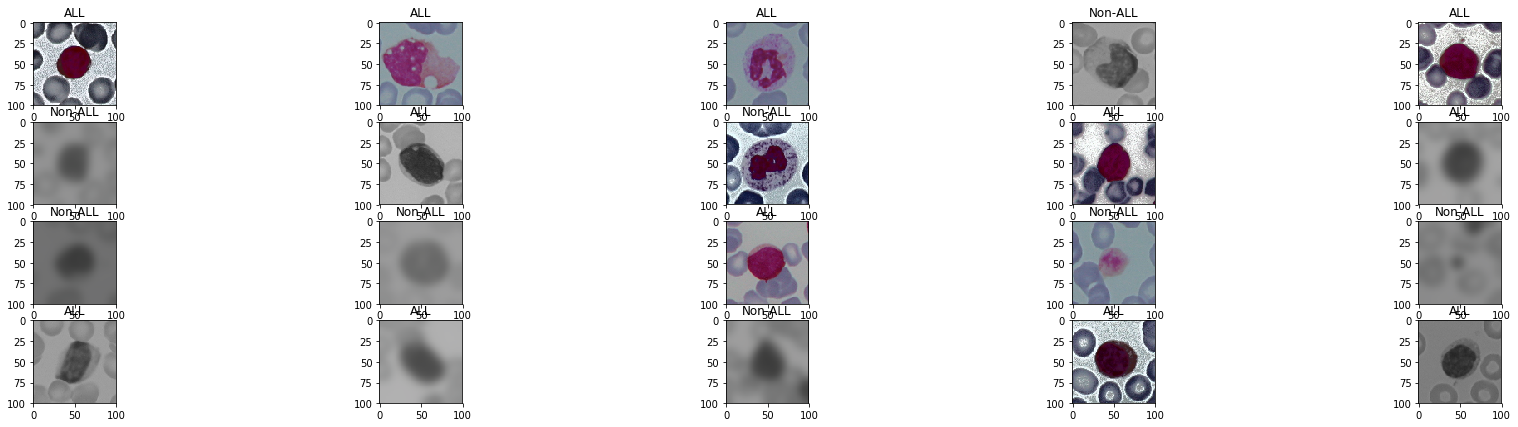

In [0]:
f, ax = plt.subplots(4,5, figsize=(30,7))
for i in range(0,20):
    ax[i//5, i%5].imshow(Data[i])
    if y[i]==1:
        ax[i//5, i%5].set_title("Non-ALL")
    else:
        ax[i//5, i%5].set_title("ALL")

### **Splitting into training and test set**

In [0]:
(X, y) = (data_list[0],data_list[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)



###**The following model was used in the paper**
Additionaly three dropout layers with different dropout rates have been used to reduce overfitting

In [0]:
model = Sequential()
model.add(Conv2D(16,(5,5),padding='valid',input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))

model.add(Conv2D(32,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))

model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Flatten())
model.add(Dense(2,activation = 'softmax'))




In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
__________

### Model compilation and fitting

In [0]:
batch_size = 100
epochs= 300

optimizer = keras.optimizers.rmsprop(lr = 0.0001, decay = 1e-6)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras_metrics.precision(), keras_metrics.recall()])

W0712 17:28:57.666712 140280406964096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0712 17:28:57.673710 140280406964096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0712 17:28:57.679484 140280406964096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history = model.fit(X_train,y_train,steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs)
history

Epoch 1/300
18/18 [==============================] - 8s 418ms/step - loss: 0.7205 - acc: 0.5058 - precision: 0.5078 - recall: 0.5115
Epoch 2/300
18/18 [==============================] - 7s 407ms/step - loss: 0.6999 - acc: 0.5052 - precision: 0.5071 - recall: 0.5158
Epoch 3/300
18/18 [==============================] - 7s 406ms/step - loss: 0.6947 - acc: 0.5137 - precision: 0.5154 - recall: 0.5303
Epoch 4/300
18/18 [==============================] - 7s 408ms/step - loss: 0.6921 - acc: 0.5191 - precision: 0.5203 - recall: 0.5413
Epoch 5/300
18/18 [==============================] - 7s 408ms/step - loss: 0.6907 - acc: 0.5253 - precision: 0.5258 - recall: 0.5576
Epoch 6/300
18/18 [==============================] - 7s 410ms/step - loss: 0.6884 - acc: 0.5359 - precision: 0.5353 - recall: 0.5737
Epoch 7/300
18/18 [==============================] - 7s 412ms/step - loss: 0.6846 - acc: 0.5521 - precision: 0.5511 - recall: 0.5824
Epoch 8/300
18/18 [==============================] - 7s 413ms/step - 

In [0]:
score = model.evaluate(X_test,y_test,verbose=0)
score

[0.2491266246025379,
 0.9081196571007754,
 0.9308755756078915,
 0.8782608691833649]

In [0]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred)

0.968551333576909

**Result for 300 epochs**

**1.Accuracy -91%**

**2.Precision -0.93**

**3.Recall -0.88**

**4. AUC score -0.97**

The model stops learning after 300 epochs



### Visualizing accuracy and loss

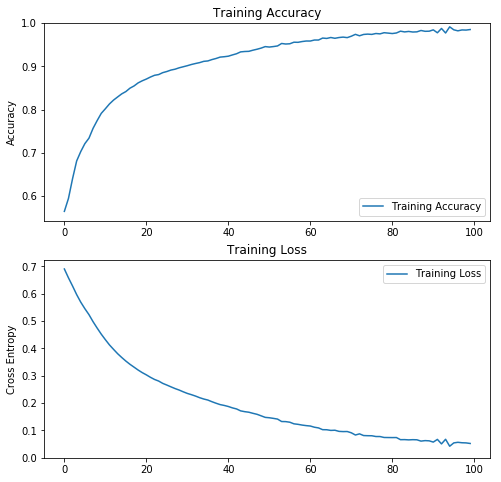

In [0]:
acc = history.history['acc']


loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss')
plt.show()

## Preparing data in order to augment it with Keras Data Generator

In [0]:
data,labels = aug_method(train_data,dim=100,method='keras')

In [0]:
data.shape

(260, 100, 100, 3)

In [0]:
data = np.asarray(data)
labels = np.asarray(labels)

In [0]:
Data,Label = shuffle(data,labels, random_state=3)
data_list = [Data,Label]
type(data_list)

list

### Train-test split

In [0]:
(X, y) = (data_list[0],data_list[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [0]:
# custom functions for histogram equalization , blurring and gray-scale to be fed into keras ImageDataGenerator as pre-processing functions
def AHE(img):
    modified = exposure.equalize_adapthist(img, clip_limit=0.03)
    return modified
  
def blur(img):
  modified = ndimage.gaussian_filter(img, sigma= 5.11) 
  return modified
def gray(img):
  aug_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  modified = np.dstack([aug_img, aug_img, aug_img]) 
  return modified
 

### **Using Keras data augmentation**

In [0]:
i = random.randrange(0,3)

if i == 0:
  data_generator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=180,zoom_range=0.1,horizontal_flip = True , vertical_flip = True,shear_range = 0.5,preprocessing_function = AHE)
elif i == 1:
  data_generator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=180,zoom_range=0.1,horizontal_flip = True , vertical_flip = True,shear_range = 0.5,preprocessing_function = blur)
elif i == 2:
  data_generator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=180,zoom_range=0.1,horizontal_flip = True , vertical_flip = True,shear_range = 0.5,preprocessing_function = gray)
  
print(i)

2


In [0]:
model = Sequential()
model.add(Conv2D(16,(5,5),padding='valid',input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))

model.add(Conv2D(32,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))

model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Flatten())
model.add(Dense(2,activation = 'softmax'))


W0712 18:45:57.928716 140280406964096 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0712 18:45:57.958403 140280406964096 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


### Model compilation and fitting

In [0]:
batch_size = 8
epochs = 100
optimizer = keras.optimizers.rmsprop(lr = 0.0001, decay = 1e-6)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras_metrics.precision(), keras_metrics.recall()])
history = model.fit_generator(data_generator.flow(X_train,y_train,batch_size = batch_size),steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs)
history

Epoch 1/100
26/26 [==============================] - 11s 418ms/step - loss: 0.6530 - acc: 0.6060 - precision: 0.6115 - recall: 0.5903
Epoch 2/100
26/26 [==============================] - 11s 408ms/step - loss: 0.6520 - acc: 0.6041 - precision: 0.6100 - recall: 0.5869
Epoch 3/100
26/26 [==============================] - 11s 410ms/step - loss: 0.6500 - acc: 0.6062 - precision: 0.6113 - recall: 0.5923
Epoch 4/100
26/26 [==============================] - 11s 413ms/step - loss: 0.6494 - acc: 0.6084 - precision: 0.6135 - recall: 0.5946
Epoch 5/100
26/26 [==============================] - 11s 415ms/step - loss: 0.6503 - acc: 0.6067 - precision: 0.6117 - recall: 0.5931
Epoch 6/100
26/26 [==============================] - 11s 417ms/step - loss: 0.6489 - acc: 0.6092 - precision: 0.6146 - recall: 0.5944
Epoch 7/100
26/26 [==============================] - 11s 420ms/step - loss: 0.6469 - acc: 0.6112 - precision: 0.6165 - recall: 0.5969
Epoch 8/100
26/26 [==============================] - 11s 422ms

In [0]:
score = model.evaluate(X_test,y_test,verbose=0)
score

[0.5359872994769332,
 0.7628205138393956,
 0.7408906879591536,
 0.7956521735671078]

In [0]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred)

0.826872488125685

**Result for 200 epochs**

**1.Accuracy -76%**

**2.Precision -0.74**

**3.Recall -0.79**

**4. AUC score -0.82**

The model stopped learning after 200 epochs

### Visualizing accuracy and loss 

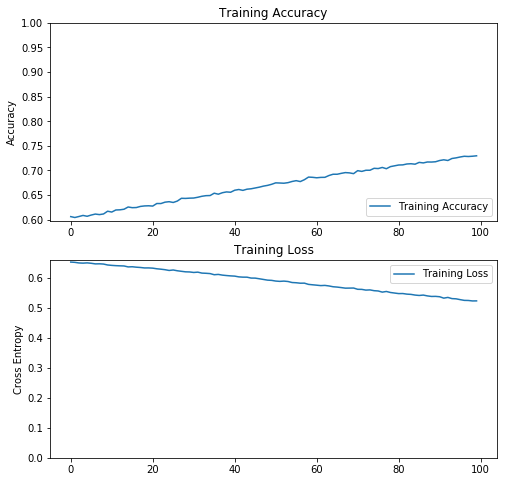

In [0]:
acc = history.history['acc']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss')
plt.show()